In [2]:
import cv2
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope

from models.unets import Unet2D
#from models.separable_unet import Separable_Unet2D
from models.deeplab import Deeplabv3, relu6, BilinearUpsampling, DepthwiseConv2D
from models.FCN import FCN_Vgg16_16s
from models.SegNet import SegNet

from utils.learning.metrics import dice_coef, precision, recall
from utils.BilinearUpSampling import BilinearUpSampling2D
from utils.io.data import load_data, save_results, save_rgb_results, save_history, load_test_images, DataGen

In [2]:
# settings
input_dim_x = 224
input_dim_y = 224
color_space = 'rgb'
path = './data/all_dog_wounds_noAugmentation/'#all_dog_wounds_noAugmentation#Medetec_foot_ulcer_224#Dog_wound_low_resolution#dog9_10_test
weight_file_name = 'Unet-dog-w-augment-2021-07-20.hdf5'
pred_save_path = 'Unet-dog-w-augment-2021-07-20/'

#data_gen = DataGen(path, split_ratio=0.0, x=input_dim_x, y=input_dim_y, color_space=color_space)
x_test, test_label_filenames_list = load_test_images(path)

In [3]:
# settings
input_dim_x = 224
input_dim_y = 224
color_space = 'rgb'
path = './data/all_dog_wounds_noAugmentation/'#all_dog_wounds_noAugmentation#Medetec_foot_ulcer_224#Dog_wound_low_resolution#dog9_10_test
weight_file_name = 'new.hdf5'
pred_save_path = 'Unet-dog-w-augment-2021-07-20/'

#data_gen = DataGen(path, split_ratio=0.0, x=input_dim_x, y=input_dim_y, color_space=color_space)
x_test, test_label_filenames_list = load_test_images(path)

In [3]:
# ### get unet model
#unet2d = Unet2D(n_filters=64, input_dim_x=input_dim_x, input_dim_y=input_dim_y, num_channels=3)
#model = unet2d.get_unet_model_yuanqing()
model = load_model('./trained_models/' + weight_file_name,
                   custom_objects={'dice_coef': dice_coef,
                                  'precision':precision,
                                  'recall':recall})

# ### get separable unet model
# sep_unet = Separable_Unet2D(n_filters=64, input_dim_x=input_dim_x, input_dim_y=input_dim_y, num_channels=3)
# model, model_name = sep_unet.get_sep_unet_v2()
# model = load_model('./azh_wound_care_center_diabetic_foot_training_history/' + weight_file_name
#                , custom_objects={'dice_coef': dice_coef,
#                                  'relu6':relu6,
#                                  'DepthwiseConv2D':DepthwiseConv2D,
#                                  'BilinearUpsampling':BilinearUpsampling})

# ### get VGG16 model
# model, model_name = FCN_Vgg16_16s(input_shape=(input_dim_x, input_dim_y, 3))
# with CustomObjectScope({'BilinearUpSampling2D':BilinearUpSampling2D}):
#     model = load_model('./azh_wound_care_center_diabetic_foot_training_history/' + weight_file_name
#                    , custom_objects={'dice_coef': dice_coef})

# ### get mobilenetv2 model
#model = Deeplabv3(input_shape=(input_dim_x, input_dim_y, 3), classes=1)
#model = load_model('./azh_wound_care_center_diabetic_foot_training_history/' + weight_file_name
#               , custom_objects={'dice_coef': dice_coef,
#                                 'relu6':relu6,
#                                 'DepthwiseConv2D':DepthwiseConv2D,
#                                 'BilinearUpsampling':BilinearUpsampling})

# ### get segnet model
######### SegNet ##########
#segnet = SegNet(n_filters=32, input_dim_x=input_dim_x, input_dim_y=input_dim_y, num_channels=3)
#model, model_name = segnet.get_SegNet()
#model = load_model('./merged_azh_dog1_8_history/' + weight_file_name,
#                   custom_objects={'dice_coef': dice_coef,
#                                  'precision':precision,
#                                  'recall':recall})

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
# Generate predicted mask images
prediction = model.predict(x_test, verbose=1)
save_results(prediction, 'rgb', path + 'predictions/' + pred_save_path, test_label_filenames_list)

17/17 [==============================] - 1s 55ms/step


## Count the wound area

In [6]:
# Create the pandas DataFrame to store wound area results
wound_area_df = pd.DataFrame(columns = ['Pixel_Area'], index = test_label_filenames_list) 

for i in range(len(test_label_filenames_list)):
    pred = prediction[i]
    ret, pred_bw = cv2.threshold(pred*255., 127, 255, cv2.THRESH_BINARY) 
    wound_area_df.iloc[i,0] = cv2.countNonZero(pred_bw)
#print(wound_area_df)

## Extract date and dog label information from row name

In [7]:
import re
for i in range(len(wound_area_df.index)):
    wound_area_df.loc[wound_area_df.index[i], 'Day'] = int(wound_area_df.index[i].split('-D')[1].split('-')[0])
    wound_area_df.loc[wound_area_df.index[i], 'Dog_label'] = wound_area_df.index[i].split('-')[1].split('-CON')[0]
print(wound_area_df.index)

Index(['-01-CON-D00-L.png', '-01-CON-D02-L.png', '-01-CON-D04-L.png',
       '-01-CON-D07-L.png', '-01-CON-D09-L.png', '-01-CON-D11-L.png',
       '-01-CON-D14-L.png', '-01-CON-D16-L.png', '-01-CON-D18-L.png',
       '-01-CON-D21-L.png',
       ...
       'rotate90-10-CON-D04-R.png', 'rotate90-10-CON-D07-R.png',
       'rotate90-10-CON-D09-R.png', 'rotate90-10-CON-D11-R.png',
       'rotate90-10-CON-D14-R.png', 'rotate90-10-CON-D16-R.png',
       'rotate90-10-CON-D18-R.png', 'rotate90-10-CON-D21-R.png',
       'rotate90-10-CON-D23-R.png', 'rotate90-10-CON-D25-R.png'],
      dtype='object', length=544)


## Find the ratio by calculate the pixel length of 1cm ruler on image

Currently just manually count pixel length of 1 cm ruler
Alternatives: 
1. Hough transform for line detection
2. A separate NN for ruler detection, and count the 1 cm ruler area

In [8]:
# Dog 9 and 10 ration manually picked
#wound_area_df.loc[:,'Ratio'] = [56, 59, 52, 50, 60, 61, 59, 63, 61, 64, 71, 73, 74, 114,
#                             50, 54, 54, 57, 57, 59, 50, 68, 81, 70, 68, 59]

# All dog wound images' ratio, could also read in from file wound_image_labels.csv
wound_area_df.loc[:,'Ratio'] = [35,66,53,54,77,70,62,72,71,71,89,81,65,68,69,30,48,60,66,65,
66,66,64,74,57,69,75,73,74,82,35,56,51,62,69,74,79,90,73,66,73,72,69,74,52,33,40,52,58,66,69,
48,69,68,55,62,64,79,83,64,50,58,64,75,75,96,70,75,63,72,51,48,53,45,53,53,54,50,55,54,67,72,
78,69,60,51,50,57,53,60,53,55,70,71,80,91,86,70,55,57,52,65,60,69,62,75,80,76,80,82,56,59,52,
50,60,61,59,63,61,64,71,73,74,114,50,54,54,57,57,59,50,68,81,70,68,59]*4

wound_area_df.loc[:,'Area_mm2'] = wound_area_df.loc[:,'Pixel_Area']*100 / (wound_area_df.loc[:,'Ratio']**2)
#print(wound_area_df)
wound_area_df = wound_area_df[['Day', 'Dog_label', 'Area_mm2']]

In [9]:
print(wound_area_df[wound_area_df.Dog_label == "07"])

                             Day Dog_label Area_mm2
-07-CON-D00-R.png            0.0        07    451.2
-07-CON-D02-R.png            2.0        07  526.008
-07-CON-D04-R.png            4.0        07  428.765
-07-CON-D07-R.png            7.0        07  450.778
-07-CON-D09-R.png            9.0        07  244.357
-07-CON-D11-R.png           11.0        07  146.116
-07-CON-D14-R.png           14.0        07  81.4694
-07-CON-D16-R.png           16.0        07  64.4118
-07-CON-D18-R.png           18.0        07  38.3125
-07-CON-D21-R.png           21.0        07  28.7284
-07-CON-D23-R.png           23.0        07  17.2255
-07-CON-D25-R.png           25.0        07  5.91837
rotate180-07-CON-D00-R.png   0.0        07   449.44
rotate180-07-CON-D02-R.png   2.0        07  537.765
rotate180-07-CON-D04-R.png   4.0        07  426.522
rotate180-07-CON-D07-R.png   7.0        07  449.056
rotate180-07-CON-D09-R.png   9.0        07  243.005
rotate180-07-CON-D11-R.png  11.0        07  136.959
rotate180-07

## Extract the intermediate layer as features

In [10]:
# Extract the intermediate layer as features
########### SegNet ####################################
# !check the summary to confirm which layer to extract
#
# Segnet: use 'conv2d_5'
# Unet: use 'conv2d_12'

layer_name = 'conv2d_12'
#layer_name = 'conv2d_5'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_test)
print(intermediate_output.shape)
# flatten the extracted features using the 1-3 column
intermediate_output_flatten = intermediate_output.reshape((intermediate_output.shape[0],
                                                           intermediate_output.shape[1] * 
                                                           intermediate_output.shape[2] * 
                                                           intermediate_output.shape[3]))
print(intermediate_output_flatten.shape)
print("Are there any NA value? : ", np.any(np.isnan(intermediate_output_flatten)))

(544, 14, 14, 256)
(544, 50176)
Are there any NA value? :  False


In [11]:
# Use PCA to reduce dimension to 50 for the regression model

# change to a pandas dataframe
og_data = pd.DataFrame(intermediate_output_flatten, index = test_label_filenames_list)
#og_data.shape
#print(og_data)

# Data normalization

#minmax data transformation
from sklearn import preprocessing
#built up data frame
from pandas import DataFrame, Series
norm_data = og_data

# Scale RNAseq data using zero-one normalization
norm_data_zerone = preprocessing.MinMaxScaler().fit_transform(norm_data)

# If select the minmax method
norm_data = pd.DataFrame(norm_data_zerone)
norm_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,50166,50167,50168,50169,50170,50171,50172,50173,50174,50175
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.141906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.954642,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005005
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## PCA Projection

In [12]:
# PCA Projection using Minka's MLE
from sklearn.decomposition import PCA
# use this, if selecting the amount of variance that needs to be explained is greater than the percentage specified by n_components.
# or assign a certain components number, e.g. 50
pca = PCA(n_components = 0.95, svd_solver = 'full')
#pca = PCA(n_components = 50, svd_solver = 'auto')
#print(pca)
principalComponents = pca.fit_transform(norm_data)
principalDf = pd.DataFrame(data = principalComponents, index = test_label_filenames_list)
#principalDf.head(5)

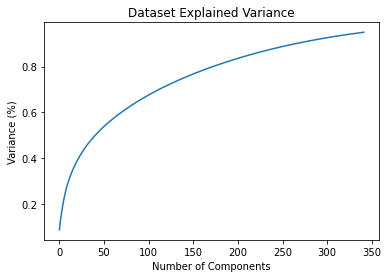

In [13]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
#plt.savefig('PCA_Explained_Variance(thre_0.9).png')
plt.show()

# VAE compression
## Split 10% of the data as test set randomly

In [14]:
#import the data as training data
#set the random state to 42

# Split 10% test set randomly
test_set_percent = 0.1
Exprframe_test = norm_data.sample(frac=test_set_percent, random_state = 42)
Exprframe_train = norm_data.drop(Exprframe_test.index)
print("The dimension of training dataset is: ",Exprframe_train.shape)

The dimension of training dataset is:  (490, 50176)


## Load functions and classes
* This will facilitate connections between layers and also custom hyperparameters

## Implementing Warm-up as described in Sonderby et al. LVAE

* This is modified code from https://github.com/fchollet/keras/issues/2595

In [15]:
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras import losses
from keras.callbacks import Callback
import keras
from keras import utils
from keras_tqdm import TQDMNotebookCallback
import tensorflow as tf

# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    #def vae_loss(self, x_input, x_decoded):
    #    reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
    #    kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
    #                            K.exp(z_log_var_encoded), axis=-1)
    #    return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))
    
    def vae_loss(self, x_input, x_decoded):
        #per sample
        reconstruction_loss = original_dim * losses.mean_absolute_error(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        
        #
        #per data point
        #reconstruction_loss = losses.mean_absolute_error(x_input, x_decoded)
        #kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
        #                        K.exp(z_log_var_encoded), axis=-1) / latent_dim
        
        
        return K.mean(reconstruction_loss + alpha * (kl_loss))#K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))


    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)    

## Set hyper parameters

In [16]:
# Set hyper parameters
tf.config.experimental_run_functions_eagerly(True)

original_dim = Exprframe_train.shape[1]
print("The dimension of input layer is: ", original_dim)

layer1_dim, layer2_dim, layer3_dim, layer4_dim, layer5_dim, latent_dim = 6000, 3000, 1000,500,100,50

batch_size = 4 #Exprframe_train.shape[0]
print("The batch size is: ", batch_size)
epochs, learning_rate = 1200, 0.002

#set kernel initializer
# Casey paper 'glorot_uniform'
#initial_method = 'glorot_uniform'
#initial_method = keras.initializers.glorot_uniform(seed=807)
initial_method = keras.initializers.glorot_normal(seed=42)

epsilon_std, alpha, beta, kappa = 1.0, 1.0, K.variable(0), 0.002

The dimension of input layer is:  50176
The batch size is:  4


## Encoder network

In [17]:
#simple neural network version with two layers
#Layer 1
# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

#L1
l1_dense_linear = Dense(layer1_dim, kernel_initializer=initial_method)(rnaseq_input)
l1_dense_batchnorm = BatchNormalization()(l1_dense_linear)
l1 = Activation('relu')(l1_dense_batchnorm)

#l2
l2_dense_linear = Dense(layer2_dim, kernel_initializer=initial_method)(l1)
l2_dense_batchnorm = BatchNormalization()(l2_dense_linear)
l2 = Activation('relu')(l2_dense_batchnorm)

#l3
l3_dense_linear = Dense(layer3_dim, kernel_initializer=initial_method)(l2)
l3_dense_batchnorm = BatchNormalization()(l3_dense_linear)
l3 = Activation('relu')(l3_dense_batchnorm)

#l4
l4_dense_linear = Dense(layer4_dim, kernel_initializer=initial_method)(l3)
l4_dense_batchnorm = BatchNormalization()(l4_dense_linear)
l4 = Activation('relu')(l4_dense_batchnorm)

#l5
l5_dense_linear = Dense(layer5_dim, kernel_initializer=initial_method)(l4)
l5_dense_batchnorm = BatchNormalization()(l5_dense_linear)
l5 = Activation('relu')(l5_dense_batchnorm)

#Layer 6
# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor

z_mean_dense_linear = Dense(latent_dim, kernel_initializer=initial_method)(l5)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer=initial_method)(l5)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

## Decoder Network

In [18]:
# The decoding layers have 6 layers and relu activation
decoderl5_reconstruct = Dense(layer5_dim, kernel_initializer=initial_method, activation='relu')
decoder_l5 = decoderl5_reconstruct(z)

decoderl4_reconstruct = Dense(layer4_dim, kernel_initializer=initial_method, activation='relu')
decoder_l4 = decoderl4_reconstruct(decoder_l5)

decoderl3_reconstruct = Dense(layer3_dim, kernel_initializer=initial_method, activation='relu')
decoder_l3 = decoderl3_reconstruct(decoder_l4)

decoderl2_reconstruct = Dense(layer2_dim, kernel_initializer=initial_method, activation='relu')
decoder_l2 = decoderl2_reconstruct(decoder_l3)

decoderl1_reconstruct = Dense(layer1_dim, kernel_initializer=initial_method, activation='relu')
decoder_l1 = decoderl1_reconstruct(decoder_l2)

decoderl0_reconstruct = Dense(original_dim, kernel_initializer=initial_method, activation='relu')
rnaseq_reconstruct = decoderl0_reconstruct(decoder_l1)

## Connect the encoder and decoder to make the VAE

* The CustomVariationalLayer() includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

* The VAE is compiled with an Adam optimizer and built-in custom loss function. The loss_weights parameter ensures beta is updated at each epoch end callback

In [19]:
from keras import losses
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

#########################################################################
#only use to manually set initial weights, otherwise change the initializer
weights = vae.get_weights()
#new_weight = [item*0+0.01 for item in weights]
#vae.set_weights(new_weight)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50176)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 6000)         301062000   input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 6000)         24000       dense[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 6000)         0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Train the model

* The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [ ]:
%%time
hist = vae.fit(np.array(Exprframe_train),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(Exprframe_test), None),
               callbacks=[WarmUpCallback(beta, kappa)])#,
                          #TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

## Visualize VAE training performance

In [ ]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
history_df = history_df.iloc[60:1199]

hist_plot_file = "temp.pdf"#
ax = history_df.plot()

ratio = 0.95
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
# the abs method is used to make sure that all numbers are positive
# because x and y axis of an axes maybe inversed.
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

ax.set_xlabel('Epochs')
ax.set_ylabel('objective function (include both reconstruct_loss, kl_loss)')
ax.set_title('')
fig = ax.get_figure()
#fig.savefig(hist_plot_file)

## Extract Encoder model

In [ ]:
#extract the encoder part
encoder = Model(rnaseq_input, z)
#encoder.summary()
# Encode rnaseq into the hidden/latent representation - and save output
z_df = encoder.predict_on_batch(Exprframe_test)

z_df = pd.DataFrame(z_df, index=Exprframe_test.index)

z_df.columns.name = 'sample_id'
z_df.columns = z_df.columns + 1
z_df.head(5)

## Extract Decoder model

In [ ]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector

_x_decoded_l5 = decoderl5_reconstruct(decoder_input)
_x_decoded_l4 = decoderl4_reconstruct(_x_decoded_l5)
_x_decoded_l3 = decoderl3_reconstruct(_x_decoded_l4)

_x_decoded_l2 = decoderl2_reconstruct(_x_decoded_l3)

_x_decoded_l1 = decoderl1_reconstruct(_x_decoded_l2)
_x_decoded_l0 = decoderl0_reconstruct(_x_decoded_l1)

decoder = Model(decoder_input, _x_decoded_l0)
#decoder.summary()

## Observe reconstruction fidelity

In [ ]:
#original input RNAseq data
Exprframe_test.head(10)

In [ ]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(z_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=Exprframe_test.index,
                                        columns=Exprframe_test.columns)
input_rnaseq_reconstruct.head(10)

## Print out the mean reconstruction loss and the mean KL loss

In [ ]:
import tensorflow as tf
# L1 loss: losses.mean_absolute_error
reconstruction_loss_used = losses.mean_absolute_error(Exprframe_test, input_rnaseq_reconstruct) #* original_dim
with tf.Session() as sess:
    #print the reconstruction loss that we calculated
    mean_reconstruct_loss = sess.run(K.mean(reconstruction_loss_used))
    print ("The mean reconstruction loss for each data point is: %.11f" % mean_reconstruct_loss)

#kl_loss = - 0.5 * K.sum(1 + z_log_var_d - K.square(z_mean_d) - 
#                                K.exp(z_log_var_d), axis=-1) / latent_dim
#with tf.Session() as sess:
    #print the kl loss that we calculated
#    mean_kl_loss = sess.run(K.mean(kl_loss))
#    print ("The mean KL loss for each data point is: %.11f" %mean_kl_loss)

# Merge with area/day information and Save the compressed encoding

In [14]:
# For uncompressed data
#out_df = og_data.merge(wound_area_df, how='outer', left_index=True, right_index=True)

# For PCA compressed:
out_df = principalDf.merge(wound_area_df, how='outer', left_index=True, right_index=True)

# For VAE compressed:
#z_df = encoder.predict_on_batch(Exprframe)
#z_df = pd.DataFrame(z_df, index=Exprframe.index)
#z_df.columns.name = 'sample_id'
#z_df.columns = z_df.columns + 1
#out_df = z_df.merge(wound_area_df, how='outer', left_index=True, right_index=True)
#out_df.head(2)

In [15]:
encoded_file_path = path + 'extracted_features/' + pred_save_path
# uncompressed: uncompressed_features_rotations.csv
# pca compressed: pca_compressed_features_rotations.csv
# vae compressed: VAE-1_compressed_features_rotations.csv
out_df.to_csv(encoded_file_path + 'pca_compressed_features_rotations.csv', sep='\t')

In [ ]:
#print(path + 'predictions/' + pred_save_path)

In [ ]:
#for image_batch, label_batch in data_gen.generate_data(batch_size=len(x_test), test=True):
#    prediction = model.predict(image_batch, verbose=1)
    #save_results(prediction, 'rgb', path + 'test/predictions/' + pred_save_path, test_label_filenames_list)
#    break